In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
from algo import *
from util import *
from environment import *
from ids import *
from tqdm import tqdm

In [2]:
# low to high to middle
class pricing_criteo():
    def __init__(self, price_list=np.linspace(10,500,50), update_freq=100, T=3000):
        self.price_list = price_list
        self.update_freq = update_freq
        self.t = 0
        self.T = T
        self.stage_1 = pd.read_csv('./criteo data/value_low.csv')['demand']
        self.stage_2 = pd.read_csv('./criteo data/value_high.csv')['demand']
        self.stage_3 = pd.read_csv('./criteo data/value_middle.csv')['demand']
        self.click = pd.read_csv('./criteo data/click_data.csv')['click']
        self.conversion = pd.read_csv('./criteo data/click_data.csv')['conversion_rate'].mean()
        self.conversion = 1
        
    def customer_simulation(self, price, within=True):
        
        T_stage_1 = int(self.T / 3)
        T_stage_2 = T_stage_1 * 2
        click = 1000
        
        if self.t < T_stage_1:
            # click = np.random.choice(self.click)
            conversion = self.conversion * self.stage_1.loc[int((price-10)/10)]
            reaction = np.random.binomial(1, conversion, click)
#             reaction = np.zeros(click)
#             reaction[np.random.choice(click, int(conversion*click))] = 1
            self.t += 1
            
        elif (self.t >= T_stage_1) & (self.t < T_stage_2):
            # click = np.random.choice(self.click)
            conversion = self.conversion * self.stage_2.loc[int((price-10)/10)]
            reaction = np.random.binomial(1, conversion, click)
#             reaction = np.zeros(click)
#             reaction[np.random.choice(click, int(conversion*click))] = 1
            self.t += 1
            
        else:
#             click = np.random.choice(self.click)
            conversion = self.conversion * self.stage_3.loc[int((price-10)/10)]
            reaction = np.random.binomial(1, conversion, click)
#             reaction = np.zeros(click)
#             reaction[np.random.choice(click, int(conversion*click))] = 1
            self.t += 1
            
        if self.t == self.T:
            self.reset_t()
        
        # this line is for normalizing observation to 0 to 100 for comparison
        reward = sum(reaction) * price / click
        reaction = reaction / click * update_freq
        chosen_index = 0
        return reward, chosen_index, reaction

        
    def reset_t(self):
        self.t = 0
    
    def simulator_exp(self, simu=100):
        df = pd.DataFrame(columns=['t','arm','price','reward'])
        for t in [0, self.T/3, self.T*2/3]:
            for arm in tqdm(range(self.price_list.shape[0])):
                price = self.price_list[arm]
                observation = []
                all_p_y = np.zeros(shape=(update_freq+1))
                for rounds in range(simu):
                    self.t = t
                    reward, _, reaction = self.customer_simulation(self.price_list[arm])
                    df = pd.concat([df, pd.DataFrame({'t':t,'arm':arm,'price':price, 'reward':reward},index=[rounds])])
                    observation.append(sum(reaction))
                for i in range(update_freq+1):
                    all_p_y[i] = observation.count(i) / simu
        df_groups = df.groupby(['t','arm'])['reward'].mean()
        optimal_arm_1 = np.argmax(df_groups.loc[df_groups.index[0:self.price_list.shape[0]]])
        optimal_arm_2 = np.argmax(df_groups.loc[df_groups.index[self.price_list.shape[0]:self.price_list.shape[0]*2]])
        optimal_arm_3 = np.argmax(df_groups.loc[df_groups.index[self.price_list.shape[0]*2:self.price_list.shape[0]*3]])
        self.reset_t()
        return df, optimal_arm_1, optimal_arm_2, optimal_arm_3
    
    def true_optimal(self):
        df, optimal_arm_1, optimal_arm_2, optimal_arm_3= self.simulator_exp()
        print("The true optimal arm is:", optimal_arm_1, optimal_arm_2, optimal_arm_3)
        return df

In [3]:
def set_experiment_criteo(price_list=np.linspace(10,500,50), update_freq=100, T=3000):
    start = time.time()
    exp_MAB_1 = pricing_criteo(price_list=price_list,update_freq=update_freq, T=T)
    df = exp_MAB_1.true_optimal()
#     df = 0
    print('time:',time.time()-start)
    return exp_MAB_1, df

In [4]:
#changeable parameters
np.random.seed(777)
K = 50
price_list = np.linspace(10,500,K)
T = 6000

#fix parameters
update_freq = 100
trial_rounds = 10
exp_MAB_1, df = set_experiment_criteo(price_list=price_list, update_freq=update_freq, T=T)

100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

The true optimal arm is: 6 27 14
time: 11.324127912521362


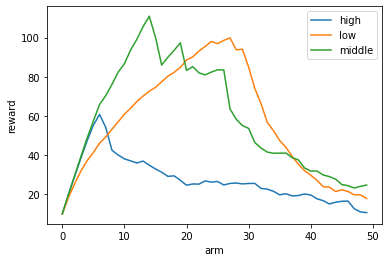

In [5]:
# Simulation
t_list = df['t'].unique()
sns.lineplot(data=df[df['t']==t_list[0]].groupby('arm')['reward'].mean())
sns.lineplot(data=df[df['t']==t_list[1]].groupby('arm')['reward'].mean())
sns.lineplot(data=df[df['t']==t_list[2]].groupby('arm')['reward'].mean())
plt.legend(['high', 'low', 'middle'])
plt.show()
# Truth
# sns.lineplot(data=exp_MAB_1.stage_1 * price_list)
# sns.lineplot(data=exp_MAB_1.stage_2 * price_list)
# sns.lineplot(data=exp_MAB_1.stage_3 * price_list)
# plt.show()

In [6]:
# #IDS_1
# IDS_1_df = pd.DataFrame()
# IDS_1_df_arm = pd.DataFrame()
# for i in range(trial_rounds):
#     start = time.time()
#     IDS_1 = IDS_pull(price_list=price_list, N=update_freq+1, start_L=2, update_L=2,
#                      simulate_time_initiate=1, simulate_time_update=1, window_width=100, eg_p=0.1)
#     IDS_1_sum, IDS_1_pt, IDS_1_re, IDS_1_arm, IDS_1_post = IDS_1.IDS(T=T, pricing_MAB=exp_MAB_1, mode='mode1',
#                                                                      update_style='none', base=1000, p=np.nan,
#                                                                      p_y=np.nan, R=np.nan)
#     end = time.time()
#     print('trial',i, 'IDS_1 time:',end-start)
#     exp_MAB_1.reset_t()
#     IDS_1_df = IDS_1_df.append([np.cumsum(IDS_1_re)])

#     IDS_1_df_arm = IDS_1_df_arm.append([IDS_1_arm])

In [7]:
# #IDST_1
# IDST_1_df = pd.DataFrame()
# IDST_1_df_arm = pd.DataFrame()
# for i in range(trial_rounds):
#     start = time.time()
#     IDST_1 = IDS_theta_pull(price_list=price_list, N=update_freq+1, start_L=2, update_L=2,
#                      simulate_time_initiate=1, simulate_time_update=1, window_width=100, eg_p=0.1)
#     IDST_1_sum, IDST_1_pt, IDST_1_re, IDST_1_arm, IDST_1_post = IDST_1.IDS(T=T, pricing_MAB=exp_MAB_1, mode='mode1',
#                                                                      update_style='none', base=1000, p=np.nan,
#                                                                      p_y=np.nan, R=np.nan)
#     end = time.time()
#     print('trial',i, 'IDST_1 time:',end-start)
#     exp_MAB_1.reset_t()
#     IDST_1_df = IDST_1_df.append([np.cumsum(IDST_1_re)])
#     IDST_1_df_arm = IDST_1_df_arm.append([IDST_1_arm])

In [8]:
#IDS_2 L=4 n=1
IDS_2_df = pd.DataFrame()
IDS_2_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    IDS_2 = IDS_pull(price_list=price_list, N=update_freq+1, start_L=4, update_L=2,
                     simulate_time_initiate=1, simulate_time_update=1, window_width=100, eg_p=0.1)
    IDS_2_sum, IDS_2_pt, IDS_2_re, IDS_2_arm, IDS_2_post = IDS_2.IDS(T=T, pricing_MAB=exp_MAB_1, mode='mode1',
                                                                     update_style='none', base=1000, p=np.nan,
                                                                     p_y=np.nan, R=np.nan)
    end = time.time()
    print('trial',i, 'IDS_2 time:',end-start)
    IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
    IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])
    
# #IDS_3 L=2 n=2
# IDS_3_df = pd.DataFrame()
# IDS_3_df_arm = pd.DataFrame()
# for i in range(trial_rounds):
#     start = time.time()
#     IDS_3 = IDS_pull(price_list=price_list, N=update_freq+1, start_L=2, update_L=2,
#                      simulate_time_initiate=2, simulate_time_update=1, window_width=100, eg_p=0.1)
#     IDS_3_sum, IDS_3_pt, IDS_3_re, IDS_3_arm, IDS_3_post = IDS_3.IDS(T=T, pricing_MAB=exp_MAB_1, mode='mode1',
#                                                                      update_style='none', base=1000, p=np.nan,
#                                                                      p_y=np.nan, R=np.nan)
#     end = time.time()
#     print('trial',i, 'IDS_3 time:',end-start)
#     IDS_3_df = IDS_3_df.append([np.cumsum(IDS_3_re)])
#     IDS_3_df_arm = IDS_3_df_arm.append([IDS_3_arm])

Reward change detected at time: 1656
Detected Sign: 1
eg triggered at  1716
arm
4.0     8.455153e-01
6.0     6.424936e-35
7.0     4.589716e-01
12.0    1.000000e+00
20.0    1.000000e+00
28.0    8.516179e-01
36.0    6.053853e-01
44.0    7.420659e-01
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2026
arm
4.0     5.525065e-02
5.0     2.966368e-01
6.0     1.295621e-01
12.0    5.441819e-11
20.0    1.766750e-17
28.0    1.369042e-11
36.0    2.049348e-04
44.0    7.831516e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2719
Detected Sign: 1
eg triggered at  2741
arm
4.0     0.142238
12.0    0.764612
20.0    0.919280
26.0    0.084362
28.0    1.000000
36.0    0.409700
44.0    0.336070
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2798
arm
4.0     0.111165
12.0    0.764754
20.0    0.361395
26.0    0.016092
28.0    0.748487
36.0    0.743689
44.0    0.113621
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 2907
Detected Sign: 1
Detector cooling
eg triggered at  2939
arm
4.0     0.137161
12.0    0.549234
20.0    0.761321
26.0    0.011255
28.0    0.831135
36.0    0.745030
44.0    0.193422
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2996
arm
4.0     0.222696
12.0    0.920513
20.0    1.000000
26.0    0.022075
28.0    0.669854
36.0    1.000000
44.0    0.114083
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 3110
Detected Sign: 1
Detector cooling
eg triggered at  3133
arm
4.0     0.176344
12.0    1.000000
20.0    0.611957
26.0    0.239238
28.0    0.523015
36.0    1.000000
44.0    0.318286
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  3148
arm
4.0     0.222600
12.0    0.689304
20.0    0.760846
26.0    0.328049
28.0    0.914774
36.0    0.741731
44.0    0.103345
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001
Reward change detected at time: 4001
Detected Sign: -1
eg triggered at  4026
arm
4.0     5.095921e-10
12.0    1.039474e-07
20.0    8.384465e-01
25.0    2.246676e-01
26.0    2.414066e-01
28.0    4.500953e-02
36.0    2.417407e-01
44.0    8.493806e-03
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 0 IDS_2 time: 1150.6155581474304


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2027
arm
4.0     1.120663e-16
5.0     9.160257e-01
6.0     2.648127e-03
12.0    5.346092e-11
20.0    3.055703e-17
28.0    8.737396e-15
36.0    9.565858e-06
44.0    8.390569e-03
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 4003
Detected Sign: -1
Detector cooling
eg triggered at  4069
arm
4.0     2.674542e-14
12.0    2.702610e-08
20.0    4.648597e-01
24.0    8.417124e-01
25.0    5.201392e-01
26.0    8.012151e-01
27.0    2.200138e-01
28.0    1.676636e-01
36.0    6.946927e-01
44.0    9.618772e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 1 IDS_2 time: 1068.7693779468536


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2013
arm
4.0     6.808732e-06
5.0     3.004190e-01
6.0     4.862277e-03
12.0    6.526926e-12
20.0    2.031220e-19
28.0    8.368531e-15
36.0    6.736729e-04
44.0    1.251814e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2803
Detected Sign: 1
eg triggered at  2809
arm
4.0     0.384567
12.0    0.764259
20.0    0.839387
26.0    0.834926
27.0    0.830091
28.0    0.915409
36.0    1.000000
44.0    1.000000
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2986
arm
4.0     0.465293
12.0    0.920700
20.0    0.919222
27.0    0.000648
28.0    0.915432
36.0    1.000000
44.0    1.000000
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 3359
Detected Sign: 1
eg triggered at  3376
arm
4.0     0.016272
12.0    0.484399
20.0    0.919385
27.0    0.980298
28.0    0.598375
36.0    1.000000
44.0    1.000000
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


eg triggered at  3485
arm
4.0     0.011195
12.0    0.422030
20.0    0.612731
27.0    0.204044
28.0    0.752094
36.0    0.646102
44.0    0.851972
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4002
Detected Sign: -1
eg triggered at  4034
arm
4.0     4.173707e-13
12.0    3.372936e-07
20.0    9.185024e-01
25.0    4.996617e-02
26.0    5.651894e-01
28.0    5.711262e-02
36.0    2.723323e-01
44.0    2.946383e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 5487
Detected Sign: 1
eg triggered at  5487
arm
4.0     0.802841
12.0    0.908243
14.0    0.824957
20.0    0.419924
28.0    0.905096
36.0    0.452832
44.0    0.066987
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  5537
arm
4.0     0.450685
12.0    0.908237
14.0    0.008939
15.0    0.049399
20.0    0.419889
28.0    0.632503
36.0    0.453958
44.0    0.008679
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 2 IDS_2 time: 1138.7807250022888


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2022
arm
4.0     4.100185e-08
5.0     6.007346e-01
6.0     3.567048e-03
12.0    2.792271e-12
20.0    2.956623e-16
28.0    3.147511e-13
36.0    5.519640e-03
44.0    4.785169e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 4001
Detected Sign: -1
Detector cooling
Detector cooling
eg triggered at  4082
arm
4.0     3.705013e-15
12.0    1.038451e-11
20.0    5.344537e-01
24.0    3.786009e-01
26.0    3.670596e-01
27.0    8.175573e-02
28.0    1.324200e-01
36.0    6.923766e-01
44.0    2.798241e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 5083
Detected Sign: 1
eg triggered at  5207
arm
4.0     0.743365
12.0    0.633834
14.0    0.002049
15.0    0.007135
20.0    0.266521
28.0    0.546535
36.0    0.548999
44.0    0.045203
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 3 IDS_2 time: 1065.851968050003


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
eg triggered at  2001
arm
4.0     3.570547e-07
6.0     5.311183e-05
12.0    7.455094e-07
20.0    2.098651e-13
28.0    1.479895e-11
36.0    1.974491e-02
44.0    5.740596e-01
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2407
Detected Sign: 1
eg triggered at  2439
arm
4.0     0.624646
12.0    1.000000
20.0    0.759347
24.0    0.080757
25.0    0.734244
28.0    1.000000
36.0    0.622407
44.0    0.027063
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2456
arm
4.0     0.136382
12.0    0.920395
20.0    0.759698
24.0    0.436009
25.0    0.835389
28.0    0.668265
36.0    0.625080
44.0    0.000716
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 3095
Detected Sign: -1
eg triggered at  3111
arm
4.0     0.000455
12.0    0.615713
20.0    0.614825
27.0    0.899226
28.0    0.833684
36.0    0.763282
44.0   

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 4 IDS_2 time: 1194.3204808235168


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2014
arm
4.0     6.680351e-06
5.0     2.244234e-01
6.0     6.375812e-04
12.0    3.926032e-10
20.0    9.095760e-19
28.0    5.174212e-19
36.0    4.544376e-04
44.0    3.059050e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 3502
Detected Sign: -1
eg triggered at  3511
arm
4.0     0.000485
12.0    0.763679
20.0    0.761380
26.0    0.597216
28.0    1.000000
36.0    0.457626
44.0    0.402192
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 3739
Detected Sign: -1
Detector cooling
Detector cooling
eg triggered at  3760
arm
4.0     0.539347
12.0    1.000000
20.0    0.760631
26.0    0.340537
28.0    0.748442
36.0    0.763045
44.0    0.549324
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  3827
arm
4.0     0.220662
12.0    0.920340
20.0    1.000000
26.0    0.558004
28

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4002
Detected Sign: -1
Detector cooling
Detector cooling
eg triggered at  4032
arm
4.0     4.634079e-11
12.0    1.007556e-07
20.0    6.084713e-01
24.0    8.914745e-03
25.0    4.588440e-01
26.0    1.000000e+00
28.0    1.422128e-01
36.0    2.592833e-01
44.0    9.043981e-03
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4233
Detected Sign: 1
eg triggered at  4242
arm
4.0     1.000000
12.0    0.816525
14.0    0.073026
20.0    0.314580
28.0    0.713075
36.0    0.266157
44.0    0.036029
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  4363
arm
4.0     0.764676
12.0    1.000000
14.0    0.000010
15.0    0.395000
20.0    0.421486
28.0    0.713043
36.0    0.457507
44.0    0.010545
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4604
Detected Sign: 1
eg triggered at  4631
arm
4.0     0.764945
12.0    1.000000
14.0    0.043755
20.0    0.227588
28.0    0.902464
36.0    0.457885
44.0    0.098953
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


eg triggered at  4753
arm
4.0     0.537892
12.0    0.907296
14.0    0.000003
20.0    0.227506
28.0    0.623356
36.0    0.265541
44.0    0.003967
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 5 IDS_2 time: 1143.5733938217163


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2012
arm
4.0     3.984379e-06
5.0     5.037803e-01
6.0     2.530773e-03
12.0    6.811858e-10
20.0    8.880153e-17
28.0    8.785860e-14
36.0    2.888490e-03
44.0    1.166103e-01
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 4002
Detected Sign: -1
eg triggered at  4066
arm
4.0     1.259967e-13
12.0    4.493745e-10
20.0    5.343837e-01
24.0    2.391546e-01
25.0    1.000000e+00
26.0    6.435735e-01
27.0    4.362368e-01
28.0    2.092691e-01
36.0    4.343453e-01
44.0    6.581110e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 6 IDS_2 time: 1102.4518520832062


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
eg triggered at  2001
arm
4.0     1.124840e-07
6.0     1.905238e-04
12.0    2.203480e-07
20.0    9.729968e-15
28.0    2.496953e-11
36.0    4.272691e-02
44.0    7.855167e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2360
Detected Sign: -1
eg triggered at  2380
arm
4.0     0.273978
12.0    0.617882
20.0    0.838192
27.0    0.631295
28.0    1.000000
36.0    0.742365
44.0    0.118326
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2417
arm
4.0     0.392582
12.0    1.000000
20.0    0.918904
27.0    0.534860
28.0    1.000000
36.0    0.513197
44.0    0.042307
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.001
Reward change detected at time: 2957
Detected Sign: -1
eg triggered at  2967
arm
4.0     0.175370
12.0    0.617068
20.0    0.918922
27.0    0.527707
28.0    0.672090
36.0    0.621653
44.0    0.325457
Name

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 3818
Detected Sign: -1
Detector cooling
eg triggered at  3824
arm
4.0     0.172982
12.0    1.000000
20.0    0.760158
27.0    0.362665
28.0    1.000000
36.0    1.000000
44.0    0.325543
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
Reward change detected at time: 4001
Detected Sign: -1
Detector cooling
eg triggered at  4042
arm
4.0     4.270556e-11
12.0    4.338917e-10
20.0    8.364078e-01
23.0    9.533411e-01
24.0    1.000000e+00
25.0    4.560137e-01
26.0    2.982775e-01
27.0    6.507730e-01
28.0    4.858304e-01
36.0    3.342573e-01
44.0    5.522469e-03
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 5222
Detected Sign: 1
eg triggered at  5243
arm
4.0     0.757546
12.0    0.482139
14.0    0.140663
15.0    0.069483
20.0    0.421290
28.0    0.809279
36.0    0.726407
44.0    0.164735
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


eg triggered at  5889
arm
4.0     1.000000e+00
12.0    4.917397e-01
14.0    2.401576e-51
15.0    1.033927e-27
20.0    5.441849e-01
28.0    3.981027e-01
36.0    4.561211e-01
44.0    1.777671e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


trial 7 IDS_2 time: 1150.6268103122711


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2012
arm
4.0     8.004685e-08
5.0     7.081514e-01
6.0     9.114611e-03
12.0    7.265538e-12
20.0    1.485942e-15
28.0    1.006834e-14
36.0    3.784551e-04
44.0    7.138089e-03
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2607
Detected Sign: 1
Detector cooling
eg triggered at  2626
arm
4.0     0.020430
12.0    0.920672
20.0    0.759774
27.0    0.313075
28.0    0.672233
36.0    0.529412
44.0    0.329001
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  2744
arm
4.0     0.002598
12.0    1.000000
20.0    1.000000
27.0    0.015554
28.0    0.397048
36.0    1.000000
44.0    0.039942
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4003
Detected Sign: -1
Detector cooling
Detector cooling
Detector cooling
Detector cooling
Detector cooling
Detector cooling
Detector cooling
Detector cooling
eg triggered at  4025
arm
4.0     4.558966e-11
12.0    3.205365e-08
20.0    1.000000e+00
25.0    1.696254e-02
26.0    3.266686e-01
28.0    7.519460e-02
36.0    3.431068e-01
44.0    1.020154e-02
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4268
Detected Sign: 1
eg triggered at  4280
arm
4.0     1.000000
12.0    0.646686
14.0    0.176062
20.0    0.615048
28.0    0.721850
36.0    0.076724
44.0    0.013240
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


eg triggered at  4326
arm
4.0     1.000000
12.0    0.908965
14.0    0.009963
20.0    0.481402
28.0    0.405529
36.0    0.076518
44.0    0.004995
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 4707
Detected Sign: 1
eg triggered at  4715
arm
4.0     1.000000
12.0    1.000000
14.0    0.096338
20.0    0.267876
28.0    0.721849
36.0    0.437246
44.0    0.040568
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
Reward change detected at time: 4772
Detected Sign: 1
eg triggered at  4800
arm
4.0     1.000000
12.0    1.000000
14.0    0.012709
20.0    0.481181
28.0    0.905568
36.0    0.169178
44.0    0.040639
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


eg triggered at  4913
arm
4.0     0.799938
12.0    0.251045
14.0    0.000007
20.0    0.481402
28.0    0.552758
36.0    0.076517
44.0    0.004995
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 5195
Detected Sign: -1
eg triggered at  5201
arm
4.0     1.000000
12.0    0.564019
14.0    0.932674
20.0    0.419679
28.0    0.632347
36.0    0.167430
44.0    0.037986
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  5342
arm
4.0     0.590283
12.0    0.564559
14.0    0.000006
20.0    0.686172
28.0    0.473176
36.0    0.243390
44.0    0.004673
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 5649
Detected Sign: 1
eg triggered at  5658
arm
4.0     1.000000
12.0    0.818774
14.0    0.131551
20.0    0.615014
28.0    0.552753
36.0    0.437071
44.0    0.013245
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  5671
arm
4.0     1.000000
12.0    0.908926
14.0    0.257914
20.0    0.615053
28.0    0.721850
36.0    0.076725
44.0    0.001790
Name: pvalue, dtype: float64
demand shape does not match
trial 8 IDS_2 time: 1177.2085092067719


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


Reward change detected at time: 2001
Detected Sign: 1
Detector cooling
eg triggered at  2015
arm
4.0     1.819409e-05
5.0     7.649867e-01
6.0     8.976201e-03
12.0    6.417479e-12
20.0    5.009957e-18
28.0    3.113913e-16
36.0    2.798991e-03
44.0    6.746888e-02
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 2368
Detected Sign: -1
eg triggered at  2437
arm
4.0     0.264226
12.0    0.920405
20.0    0.919100
26.0    0.091964
28.0    0.670192
36.0    0.738485
44.0    0.048960
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Detector cooling
Detector cooling
Detector cooling
Detector cooling
Detector cooling
eg triggered at  2745
arm
4.0     3.249702e-01
12.0    6.903994e-01
20.0    9.191260e-01
26.0    3.179726e-08
28.0    3.915216e-01
36.0    6.148117e-01
44.0    3.627527e-03
Name: pvalue, dtype: float64
demand shape does not match


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Reward change detected at time: 3856
Detected Sign: 1
eg triggered at  3862
arm
4.0     0.269547
12.0    0.842074
20.0    1.000000
26.0    0.429298
28.0    1.000000
36.0    0.399909
44.0    0.033819
Name: pvalue, dtype: float64
tested non-significant , eg_p decayed to 0.010000000000000002
eg triggered at  3898
arm
4.0     0.393178
12.0    0.920453
20.0    0.477239
26.0    0.311274
28.0    0.519438
36.0    0.396111
44.0    0.000993
Name: pvalue, dtype: float64
demand shape does not match
Reward change detected at time: 5769
Detected Sign: -1
Detector cooling
Detector cooling
eg triggered at  5780
arm
4.0     2.523751e-13
12.0    1.064187e-10
20.0    6.768431e-01
24.0    5.194210e-01
28.0    2.983084e-01
36.0    1.614036e-01
44.0    2.971978e-02
Name: pvalue, dtype: float64
demand shape does not match
trial 9 IDS_2 time: 1014.8798098564148


<ipython-input-8-cf9ecd5c1fc8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df = IDS_2_df.append([np.cumsum(IDS_2_re)])
<ipython-input-8-cf9ecd5c1fc8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDS_2_df_arm = IDS_2_df_arm.append([IDS_2_arm])


In [9]:
#IDS with window likelihood
IDSW_df = pd.DataFrame()
IDSW_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    IDSW = IDS_pull(price_list=price_list, N=update_freq+1, start_L=4, update_L=0, update_during_exploit=True,
                     simulate_time_initiate=1, simulate_time_update=1, window_width=100, eg_p=0)
    IDSW_sum, IDSW_pt, IDSW_re, IDSW_arm, IDSW_post = IDSW.IDS(T=T, pricing_MAB=exp_MAB_1, mode='mode1',
                                                                     update_style='none', base=1000, p=np.nan,
                                                                     p_y=np.nan, R=np.nan)
    end = time.time()
    print('trial',i, 'IDSW time:',end-start)
    IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
    IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])

trial 0 IDSW time: 1763.7441141605377


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 1 IDSW time: 10501.962987184525
trial 2 IDSW time: 2128.5384612083435


<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 3 IDSW time: 1777.123305797577


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 4 IDSW time: 1784.1291899681091


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 5 IDSW time: 1783.0719521045685


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 6 IDSW time: 1787.4127218723297


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 7 IDSW time: 1784.046266078949


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 8 IDSW time: 7620.406838178635


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


trial 9 IDSW time: 1764.0095429420471


<ipython-input-9-fc7c875b105a>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df = IDSW_df.append([np.cumsum(IDSW_re)])
<ipython-input-9-fc7c875b105a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IDSW_df_arm = IDSW_df_arm.append([IDSW_arm])


In [10]:
segments=1
# UCB1 c=1
UCB_1_df = pd.DataFrame()
UCB_1_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    UCB1 = UCBPI_pull(price_list=price_list, segments=segments, c=1, bias=0, UCB1=True, tuned=False)
    UCB1_sum, UCB1_pt, UCB1_re, UCB1_arm = UCB1.UCBPI(T=T, pricing_MAB=exp_MAB_1)
    end = time.time()
    print('trial',i, 'UCB_1 time:',end-start)
    UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
    UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])

# UCB1 c=2
UCB_2_df = pd.DataFrame()
UCB_2_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    UCB1 = UCBPI_pull(price_list=price_list, segments=segments, c=2, bias=0, UCB1=True, tuned=False)
    UCB1_sum, UCB1_pt, UCB1_re, UCB1_arm = UCB1.UCBPI(T=T, pricing_MAB=exp_MAB_1)
    end = time.time()
    print('trial',i, 'UCB_2 time:',end-start)
    UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
    UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])
    

# UCB-tuned
UCBT_df = pd.DataFrame()
UCBT_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    UCB1 = UCBPI_pull(price_list=price_list, segments=segments, c=2, bias=0, UCB1=True, tuned=True)
    UCB1_sum, UCB1_pt, UCB1_re, UCB1_arm = UCB1.UCBPI(T=T, pricing_MAB=exp_MAB_1)
    end = time.time()
    print('trial',i, 'UCB-tuned time:',end-start)
    UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
    UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])
    
    
# TS
TS_df = pd.DataFrame()
TS_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    TS = TS_pull(price_list=price_list, est='MEAN', update_freq=update_freq)
    TS_sum, TS_pt, TS_re, TS_arm = TS.TS(T=T, pricing_MAB=exp_MAB_1)
    end = time.time()
    print('trial',i, 'TS time:',end-start)
    TS_df = TS_df.append([np.cumsum(TS_re)])
    TS_df_arm = TS_df_arm.append([TS_arm])

# EG e=0.05
EG_1_df = pd.DataFrame()
EG_1_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    EG = EG_pull(price_list=price_list)
    EG_sum, EG_pt, EG_re, EG_arm = EG.EG(T=T, pricing_MAB=exp_MAB_1, e=0.05)
    end = time.time()
    print('trial',i, 'EG 0.05 time:',end-start)
    EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
    EG_1_df_arm = EG_1_df_arm.append([EG_arm])

# EG p=0.1
EG_2_df = pd.DataFrame()
EG_2_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    EG = EG_pull(price_list=price_list)
    EG_sum, EG_pt, EG_re, EG_arm = EG.EG(T=T, pricing_MAB=exp_MAB_1, e=0.1)
    end = time.time()
    print('trial',i, 'EG 0.1 time:',end-start)
    EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
    EG_2_df_arm = EG_2_df_arm.append([EG_arm])
    
# EG e=0.15
EG_3_df = pd.DataFrame()
EG_3_df_arm = pd.DataFrame()
for i in range(trial_rounds):
    start = time.time()
    EG = EG_pull(price_list=price_list)
    EG_sum, EG_pt, EG_re, EG_arm = EG.EG(T=T, pricing_MAB=exp_MAB_1, e=0.15)
    end = time.time()
    print('trial',i, 'EG 0.15 time:',end-start)
    EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
    EG_3_df_arm = EG_3_df_arm.append([EG_arm])

trial 0 UCB_1 time: 1.2958250045776367


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 1 UCB_1 time: 1.3317770957946777
trial 2 UCB_1 time: 1.3003599643707275


<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 3 UCB_1 time: 1.3369901180267334


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 4 UCB_1 time: 1.2929420471191406


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 5 UCB_1 time: 1.3337342739105225


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 6 UCB_1 time: 1.296900987625122


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 7 UCB_1 time: 1.3380510807037354


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 8 UCB_1 time: 1.3202300071716309


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 9 UCB_1 time: 1.2956867218017578


<ipython-input-10-8e78e3575a62>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df = UCB_1_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_1_df_arm = UCB_1_df_arm.append([UCB1_arm])


trial 0 UCB_2 time: 1.3325557708740234


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 1 UCB_2 time: 1.3371808528900146
trial 2 UCB_2 time: 1.3046541213989258


<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 3 UCB_2 time: 1.3257801532745361


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 4 UCB_2 time: 1.3283820152282715


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 5 UCB_2 time: 1.337810754776001


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 6 UCB_2 time: 1.2944459915161133


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 7 UCB_2 time: 1.3362700939178467


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 8 UCB_2 time: 1.3377978801727295


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 9 UCB_2 time: 1.3387370109558105


<ipython-input-10-8e78e3575a62>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df = UCB_2_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCB_2_df_arm = UCB_2_df_arm.append([UCB1_arm])


trial 0 UCB-tuned time: 2.705233097076416


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 1 UCB-tuned time: 2.6815600395202637
trial 2 UCB-tuned time: 2.6675007343292236


<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 3 UCB-tuned time: 2.6870460510253906


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 4 UCB-tuned time: 2.6820359230041504


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 5 UCB-tuned time: 2.6789300441741943


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 6 UCB-tuned time: 2.6717529296875


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 7 UCB-tuned time: 2.71052622795105


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 8 UCB-tuned time: 2.6697819232940674


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 9 UCB-tuned time: 2.710275888442993


<ipython-input-10-8e78e3575a62>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df = UCBT_df.append([np.cumsum(UCB1_re)])
<ipython-input-10-8e78e3575a62>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  UCBT_df_arm = UCBT_df_arm.append([UCB1_arm])


trial 0 TS time: 6.3304619789123535


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 1 TS time: 6.314448833465576
trial 2 TS time: 6.3150599002838135


<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 3 TS time: 6.34004020690918


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 4 TS time: 6.308647871017456


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 5 TS time: 6.3346641063690186


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 6 TS time: 6.341614007949829


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 7 TS time: 6.309184789657593


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 8 TS time: 6.312923192977905


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 9 TS time: 6.319889068603516


<ipython-input-10-8e78e3575a62>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df = TS_df.append([np.cumsum(TS_re)])
<ipython-input-10-8e78e3575a62>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TS_df_arm = TS_df_arm.append([TS_arm])


trial 0 EG 0.05 time: 0.9491572380065918


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 1 EG 0.05 time: 0.9500150680541992
trial 2 EG 0.05 time: 0.9526488780975342


<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 3 EG 0.05 time: 0.9471859931945801


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 4 EG 0.05 time: 0.9406068325042725


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 5 EG 0.05 time: 0.950042724609375


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 6 EG 0.05 time: 0.9437251091003418


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 7 EG 0.05 time: 0.9441790580749512


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 8 EG 0.05 time: 0.9474329948425293


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 9 EG 0.05 time: 0.9428188800811768


<ipython-input-10-8e78e3575a62>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df = EG_1_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_1_df_arm = EG_1_df_arm.append([EG_arm])


trial 0 EG 0.1 time: 0.9418330192565918


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 1 EG 0.1 time: 0.947584867477417
trial 2 EG 0.1 time: 0.9558451175689697


<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 3 EG 0.1 time: 0.9495840072631836


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 4 EG 0.1 time: 0.9531588554382324


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 5 EG 0.1 time: 0.9430332183837891


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 6 EG 0.1 time: 0.945871114730835


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 7 EG 0.1 time: 0.9436337947845459


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 8 EG 0.1 time: 0.9475347995758057


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 9 EG 0.1 time: 0.9502551555633545


<ipython-input-10-8e78e3575a62>:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df = EG_2_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_2_df_arm = EG_2_df_arm.append([EG_arm])


trial 0 EG 0.15 time: 0.9378888607025146


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 1 EG 0.15 time: 0.9443891048431396
trial 2 EG 0.15 time: 0.936553955078125


<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 3 EG 0.15 time: 0.9501979351043701


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 4 EG 0.15 time: 0.93585205078125


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 5 EG 0.15 time: 0.9540579319000244


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 6 EG 0.15 time: 0.942418098449707


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 7 EG 0.15 time: 0.9461920261383057


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 8 EG 0.15 time: 0.9439120292663574


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


trial 9 EG 0.15 time: 0.9476878643035889


<ipython-input-10-8e78e3575a62>:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df = EG_3_df.append([np.cumsum(EG_re)])
<ipython-input-10-8e78e3575a62>:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EG_3_df_arm = EG_3_df_arm.append([EG_arm])


In [12]:
def draw_regret_criteo(optimal_reward, IDS_2, IDSW, UCB_1, UCB_2, UCBT, TS, EG_1, EG_2, EG_3, title, bounds=True):

    IDS_2_mean = (optimal_reward - IDS_2.mean().values)
    IDSW_mean = (optimal_reward - IDSW.mean().values)
    UCB_1_mean = (optimal_reward - UCB_1.mean().values)
    UCB_2_mean = (optimal_reward - UCB_2.mean().values)
    UCBT_mean = (optimal_reward - UCBT.mean().values)
    TS_mean = (optimal_reward - TS.mean().values)
    EG_1_mean = (optimal_reward - EG_1.mean().values)
    EG_2_mean = (optimal_reward - EG_2.mean().values)
    EG_3_mean = (optimal_reward - EG_3.mean().values)
    
    T = np.arange(EG_1.shape[1])
    trial = EG_1.shape[0]
    
    plt.figure(figsize=(30,20))
    sns.set(font_scale=2, style='white')
    
    plt.plot(EG_1_mean,alpha=1,color='#000000', linestyle='-')
    plt.plot(EG_2_mean,alpha=1,color='#000000', linestyle='-.')    
    plt.plot(EG_3_mean,alpha=1,color='#000000', linestyle='--')
    
    plt.plot(TS_mean,alpha=1,color='#666666', linestyle='-')
    
    plt.plot(UCB_1_mean,alpha=1,color='#666600', linestyle='-')
    plt.plot(UCB_2_mean,alpha=1,color='#666600', linestyle='-.')
    plt.plot(UCBT_mean,alpha=1,color='#666600', linestyle='--')
    plt.plot(IDS_2_mean,alpha=1,color='#FF6666', linestyle='-.')
    plt.plot(IDSW_mean,alpha=1,color='#FFA500', linestyle='-')
                 
    plt.legend(['EG $ε$=0.05', 'EG $ε$=0.1', 'EG $ε$-0.15', 'TS', 'UCB c=1', 'UCB c=2', 'UCB-tuned',
                'ACIDP L=4, n=1', 'ACIDP-Variant L=2, n=1'],
              bbox_to_anchor=(1, -0.05), ncol=7, fancybox=True)
    plt.title(title)
    plt.xlabel('Horizon')
    plt.ylabel('Cumulative Regret')
    plt.show()

In [13]:
r_star_1 = df[(df['t'] == 0) & (df['arm']==6)]['reward'].mean()
r_star_2 = df[(df['t'] == 2000) & (df['arm']==27)]['reward'].mean()
r_star_3 = df[(df['t'] == 4000) & (df['arm']==14)]['reward'].mean()
optimal_reward = np.append(np.repeat(r_star_1, T/3), 
                           np.append(np.repeat(r_star_2, T/3), np.repeat(r_star_3, T/3)))
optimal_reward = optimal_reward.cumsum()

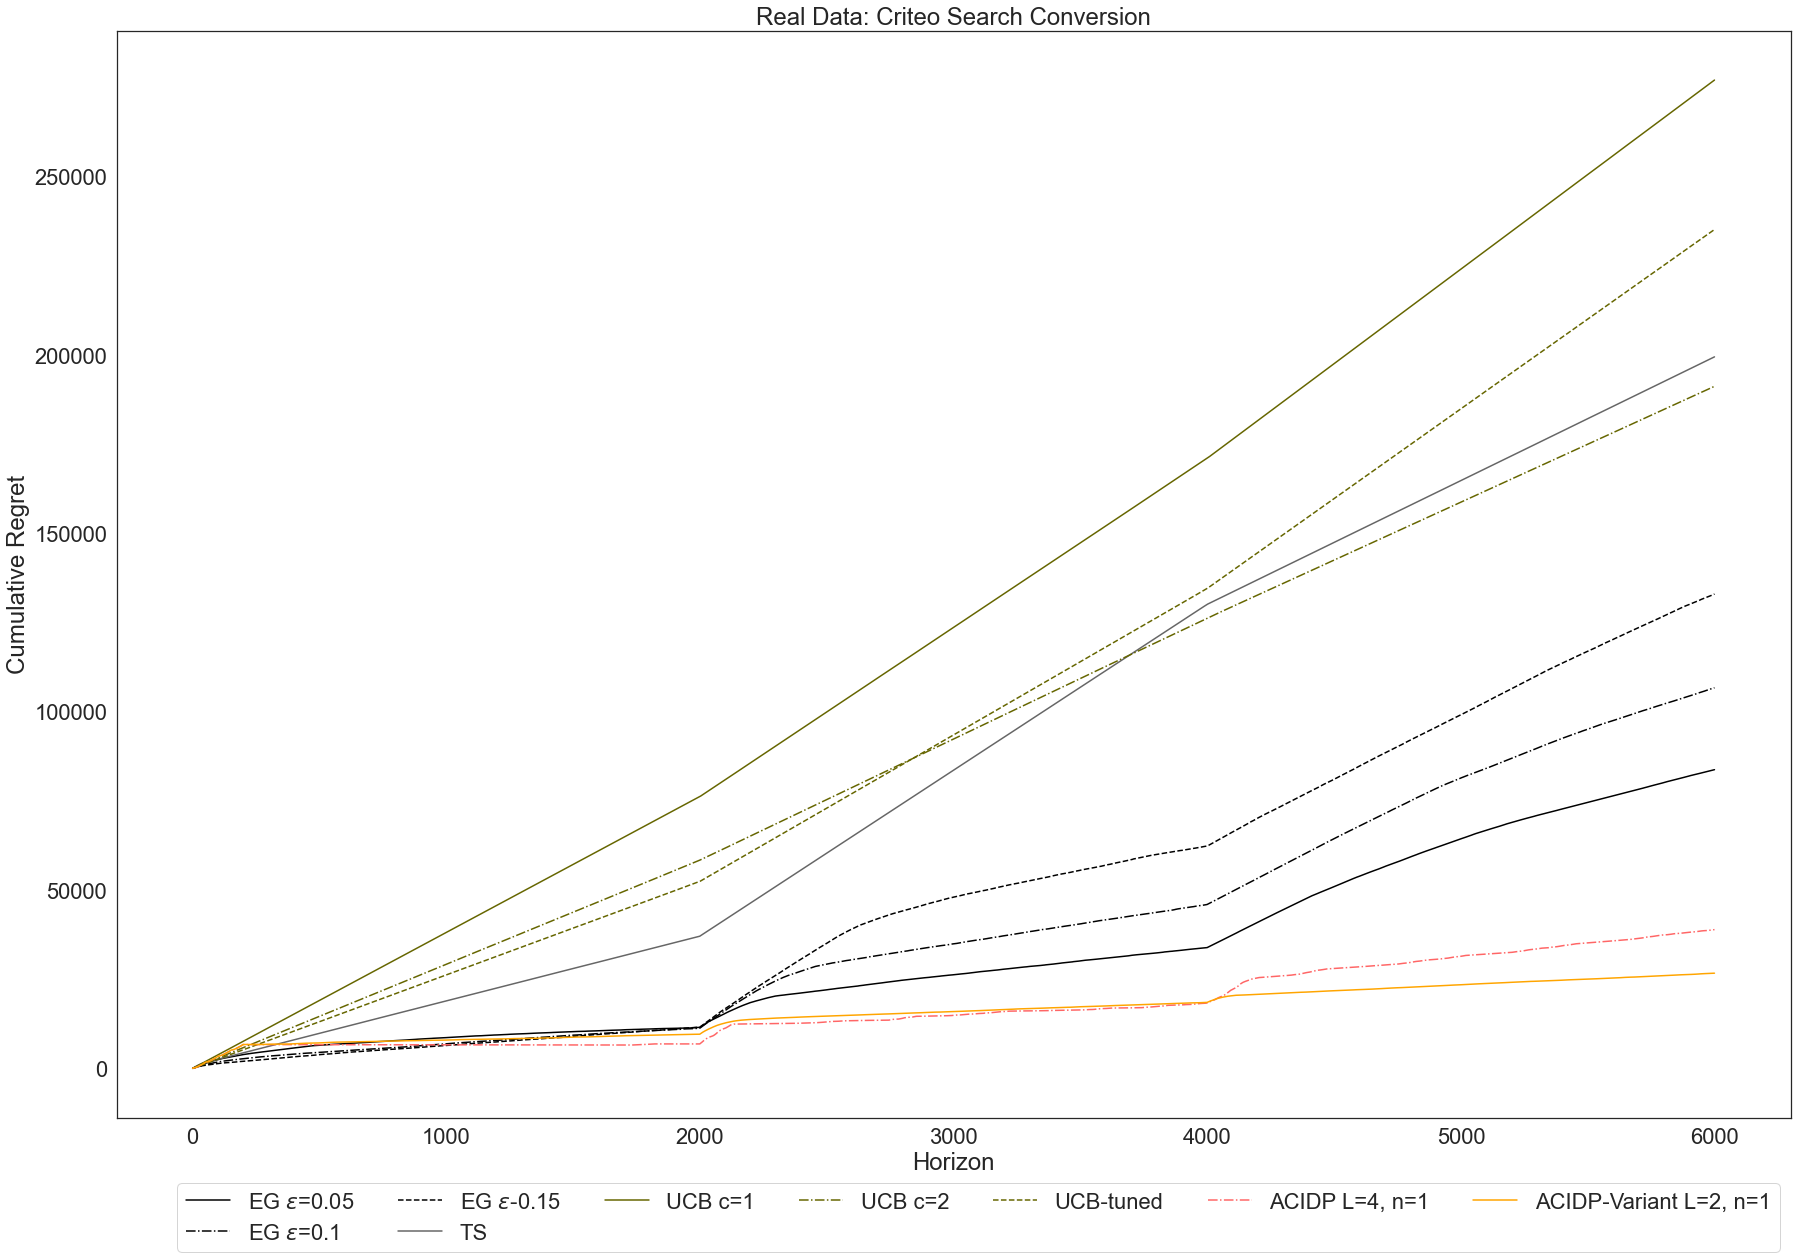

In [14]:
title = 'Real Data: Criteo Search Conversion'
draw_regret_criteo(optimal_reward, IDS_2_df, IDSW_df, UCB_1_df, UCB_2_df, UCBT_df,
                   TS_df,EG_1_df, EG_2_df, EG_3_df, title, bounds=False)

In [31]:
optimal_arm = np.append(np.repeat(5, 2000), np.append(np.repeat(27, 2000), np.repeat(14, 2000)))
draw_arm_withopt_criteo(IDS_2_df_arm.drop(columns='policy'),
                 IDSW_df_arm.drop(columns='policy'),
                 UCB_2_df_arm.drop(columns='policy'),
                 EG_1_df_arm.drop(columns='policy'),
                 optimal_arm=optimal_arm)

In [15]:
IDS_2_df['policy'] = 'IDS_2'
IDSW_df['policy'] = 'IDSW'
UCB_1_df['policy'] = 'UCB_1'
UCB_2_df['policy'] = 'UCB_2'
UCBT_df['policy'] = 'UCBT'
TS_df['policy'] = 'TS'
EG_1_df['policy'] = 'EG_1'
EG_2_df['policy'] = 'EG_2'
EG_3_df['policy'] = 'EG_3'
all_df = pd.concat([IDS_2_df, IDSW_df, UCB_1_df, UCB_2_df, UCBT_df, TS_df, EG_1_df, EG_2_df, EG_3_df])
all_df.to_csv('criteo_demo_result.csv')
all_df.groupby('policy')[5999].agg(['mean', 'std']).to_csv('criteo_regret_stats.csv')

In [18]:
IDS_2_df_arm['policy'] = 'IDS_2'
IDSW_df_arm['policy'] = 'IDSW'
UCB_1_df_arm['policy'] = 'UCB_1'
UCB_2_df_arm['policy'] = 'UCB_2'
UCBT_df_arm['policy'] = 'UCBT'
TS_df_arm['policy'] = 'TS'
EG_1_df_arm['policy'] = 'EG_1'
EG_2_df_arm['policy'] = 'EG_2'
EG_3_df_arm['policy'] = 'EG_3'
all_df_arm = pd.concat([IDS_2_df_arm, IDSW_df_arm, UCB_1_df_arm, UCB_2_df_arm, UCBT_df_arm,
                        TS_df_arm, EG_1_df_arm, EG_2_df_arm, EG_3_df_arm])
all_df_arm.to_csv('criteo_demo_result_arm.csv')

In [37]:
def draw_arm_withopt_criteo(IDS, IDSW, UCB, EG, optimal_arm):
    sns.set(font_scale=1.5, style='white')
    figure, axis = plt.subplots(2, 2, figsize=(20,12))

    trial = EG.shape[0]
    X = np.arange(EG.shape[1])
    for i in range(trial):
        axis[0, 0].scatter(x=X, y=IDS.iloc[i], alpha=0.1, s=10, color='#FF6666')
    axis[0, 0].plot(optimal_arm, color='r', linewidth=3, linestyle='--')
    axis[0, 0].set_ylim([-1, 50])
    axis[0, 0].set_ylabel('Pulled Arms')
    axis[0, 0].set_title('ACIDP')

    for i in range(trial):
        axis[0, 1].scatter(x=X, y=IDSW.iloc[i], alpha=0.1, s=10, color='#666666')
    axis[0, 1].plot(optimal_arm, color='r', linewidth=3, linestyle='--')
    axis[0, 1].set_ylim([-1, 50])
    axis[0, 1].set_ylabel('Pulled Arms')
    axis[0, 1].set_title('ACIDP-Variant')

    for i in range(trial):
        axis[1, 0].scatter(x=X, y=UCB.iloc[i], alpha=0.1, s=10, color='#666600')
    axis[1, 0].plot(optimal_arm, color='r', linewidth=3, linestyle='--')
    axis[1, 0].set_ylim([-1, 50])
    axis[1, 0].set_ylabel('Pulled Arms')
    axis[1, 0].set_title('UCB')

    for i in range(trial):
        axis[1, 1].scatter(x=X, y=EG.iloc[i], alpha=0.1, s=10, color='#996633')
    axis[1, 1].plot(optimal_arm, color='r', linewidth=3, linestyle='--')
    axis[1, 1].set_ylim([-1, 50])
    axis[1, 1].set_ylabel('Pulled Arms')
    axis[1, 1].set_title('EG')

    figure.text(0.5, 0.05, 'Horizon')
    plt.show()

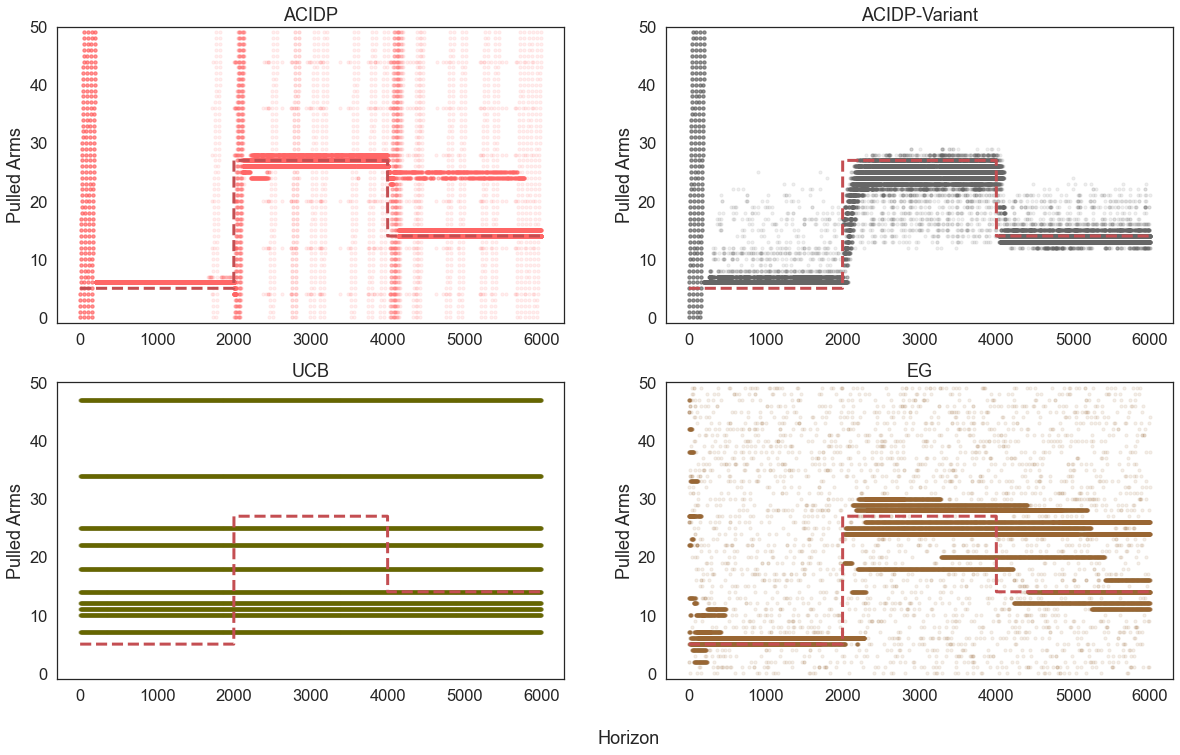

In [38]:
draw_arm_withopt(IDS_2_df_arm.drop(columns='policy'),
                 IDSW_df_arm.drop(columns='policy'),
                 UCB_2_df_arm.drop(columns='policy'),
                 EG_1_df_arm.drop(columns='policy'),
                 optimal_arm=optimal_arm)


In [40]:
optimal_reward[-1]

543011.6000000231